# 1. Parameters, Imports, and Inputs

#### Declare Important Libraries, Parameters for Dataset, and Inputs of the user

In [1]:
import numpy as np
import matplotlib.pyplot as plt

histogram_bins = 1000
samples = 1000000                        #Samples to approximate ground truth (histogramming)
samples_test = 1000                      #Dataset for training and testing
training_samples = int(0.9*samples_test)
testing_samples = int(0.1*samples_test)

In [2]:
mean = int(input("Please input the mean of the gaussian curve:"))
std_dev = int(input("Please input the stardard deviation of the gaussian curve:"))

Please input the mean of the gaussian curve:0
Please input the stardard deviation of the gaussian curve:1


# 2. Dataset and Histogramming
<ol>
<li> Draw 1,000,00 samples and store it in raw_dataset variable 
<li> Take the minimum and maximum and use linspace to know the starting values of the "bins"
<li> Declare mid_points to take the average of each histogram bins (not the starting points)
<li> Declare count to count how much values are in each "bins"
<li> Start a nested loop that has the histogram bins as the outerloop and random dataset as the inner loop. Take note that this is an inefficient solution since it would loop 1 billion times! See time elapse 
<li> Count the number of occurence and also get the midpoint of each histogram bins
    </ol>

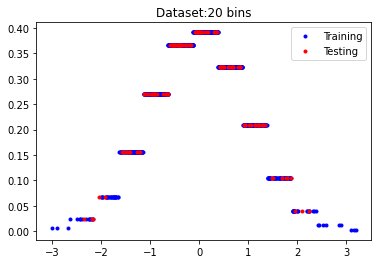

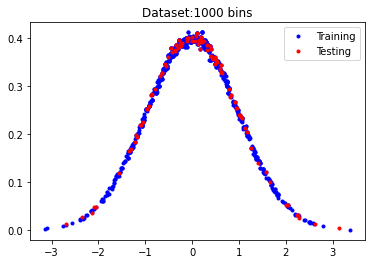

In [3]:
for i in [20,histogram_bins]:
    raw_dataset = np.random.normal(mean, std_dev,samples)
    count, bins = np.histogram(raw_dataset,bins=i,density=True)       #Takes the PDF (not PMF)
    index = np.digitize(raw_dataset,bins,right=True) - 1              #Gives the correct location of the sample - index
    ground_truth = count[index]                                       #Ground truth from 1 million samples and 1000 bins
 
    ''' Only take the first 1000 samples. Assume that np.random.normal satisfy this'''
    train_dataset = raw_dataset[:int(0.9*histogram_bins)]
    test_dataset = raw_dataset[int(0.9*histogram_bins):histogram_bins]
    train_truth = ground_truth[:int(0.9*histogram_bins)]
    test_truth = ground_truth[int(0.9*histogram_bins):histogram_bins]

    plt.figure()
    plt.plot(train_dataset,train_truth,'b.',label="Training")
    plt.plot(test_dataset,test_truth,'r.',label="Testing")
    plt.title("Dataset:"+str(i)+' bins')
    plt.legend()
    plt.show()


<h1> 3. Build a 3 layer neural network </h1>
    
Strong inspiration: https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795

In [27]:
nn_architecture = [
    {"input_dim": 1, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 1, "activation": "relu"},
]

def init_layers(nn_architecture, seed = 99):
    #np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.normal(0,0.01,(layer_output_size, layer_input_size))
        params_values['b' + str(layer_idx)] = np.random.normal(0,0.01,(layer_output_size, 1))
        
    return params_values


def relu(Z):
    return np.maximum(0,Z)
    
def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;
    


def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation == "relu":
        activation_func = relu
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

def get_cost_value(predictions,targets):
    # Retrieving number of samples in dataset
    samples_num = len(predictions)
    
    # Summing square differences between predicted and expected values
    accumulated_error = 0.0
    for prediction, target in zip(predictions, targets):
        accumulated_error += (prediction - target)**2
        
    # Calculating mean and dividing by 2
    mae_error = (1.0 / (samples_num)) * accumulated_error
    
    return mae_error

def get_accuracy_value(Y_hat, Y):
    return 100 - np.mean(np.abs(Y_hat - Y)) * 100

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation == "relu":
        backward_activation_func = relu_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
    
    dA_prev = (Y_hat - Y)/2
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
        
    
    return grads_values

def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        params_values["W" + str(layer_idx+1)] -= learning_rate * grads_values["dW" + str(layer_idx+1)]        
        params_values["b" + str(layer_idx+1)] -= learning_rate * grads_values["db" + str(layer_idx+1)]

    return params_values;

def train(X, Y, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture, 1)
    cost_history = []
    accuracy_history = []
    
    for i in range(epochs):
        for j in range(X.shape[1]):
            Y_hat, cashe = full_forward_propagation(np.array([X[0][j]])[np.newaxis,:], params_values, nn_architecture)
            cost = get_cost_value(Y_hat, np.array([Y[0][j]])[np.newaxis,:])
            cost_history.append(cost)
            accuracy = get_accuracy_value(Y_hat, np.array([Y[0][j]])[np.newaxis,:])
            accuracy_history.append(accuracy)
        
            grads_values = full_backward_propagation(Y_hat, np.array([Y[0][j]])[np.newaxis,:], cashe, params_values, nn_architecture)
        
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
    return params_values, cost_history, accuracy_history 
        
def test(X, Y, nn_architecture,params_values):
    Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
    cost = get_cost_value(Y_hat, Y)
    accuracy = get_accuracy_value(Y_hat, Y)

    return accuracy



In [28]:
params_values, cost_history, accuracy_history = train(train_dataset[np.newaxis,:],train_truth[np.newaxis,:],nn_architecture,20,0.1)
cost_history

[array([0.07090202]),
 array([0.02903264]),
 array([0.14111765]),
 array([0.02616352]),
 array([0.02068621]),
 array([0.12360649]),
 array([0.06221519]),
 array([0.11082035]),
 array([0.12681592]),
 array([0.02301575]),
 array([0.15927089]),
 array([0.00365636]),
 array([0.0977844]),
 array([0.15431135]),
 array([0.14635743]),
 array([0.13998418]),
 array([0.00969755]),
 array([0.12635491]),
 array([0.15550129]),
 array([0.1547358]),
 array([0.1547358]),
 array([0.16039327]),
 array([0.11320546]),
 array([0.00071132]),
 array([0.05490248]),
 array([0.15927089]),
 array([0.01151981]),
 array([0.12360649]),
 array([0.0797899]),
 array([0.00365636]),
 array([0.12983294]),
 array([0.11371465]),
 array([0.04515675]),
 array([0.14201144]),
 array([0.03756656]),
 array([0.13901627]),
 array([0.06665483]),
 array([0.11082035]),
 array([0.01712686]),
 array([0.15482076]),
 array([0.10528377]),
 array([0.02969875]),
 array([0.15026622]),
 array([0.08708668]),
 array([0.14993155]),
 array([0.1536

In [29]:
print(test(test_dataset[np.newaxis,:],test_truth[np.newaxis,:],nn_architecture,params_values))


71.62072770711686
